# SY32 TP01 P19

## Imports

In [4]:
import numpy as np
from sklearn.svm import LinearSVC as lsvc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import timeit
from sklearn.ensemble import RandomForestClassifier

## Naive way of doing things

In [5]:
xa = np.loadtxt('phishing_train.data.txt.txt')
ya = np.loadtxt('phishing_train.label.txt.txt')
print('xa = ', xa)
print('len xa = ', len(xa))
print('ya = ', ya)

xa =  [[-1.  1.  1. ...  0.  1. -1.]
 [-1.  1.  1. ...  0.  1. -1.]
 [-1.  1.  1. ...  1.  1. -1.]
 ...
 [ 1.  1.  1. ...  0.  1. -1.]
 [-1.  1. -1. ...  0.  1. -1.]
 [-1. -1.  1. ...  1.  1.  1.]]
len xa =  5000
ya =  [ 1.  1.  1. ...  1. -1. -1.]


In [20]:
clf = lsvc(max_iter=10000)
clf.fit(xa, ya)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Prédiciton sur les valeurs de training. Ne jamais faire !

In [19]:
pred = clf.predict(xa)
print('prediction  =', pred)

prediction  = [ 1.  1.  1. ...  1.  1. -1.]


We will charge some test data and try our clasifier those new datas

In [33]:
dt = np.loadtxt('phishing_test.txt.txt')
print(dt)

[[-1.  1.  1. ...  1.  1. -1.]
 [ 0.  1. -1. ...  0.  1. -1.]
 [-1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [-1.  1.  1. ...  1.  1. -1.]
 [-1.  1.  1. ...  1.  1. -1.]]


In [36]:
predtest = clf.predict(dt)
np.savetxt('prediction.txt',predtest)

Result : 15,24 error instead of the 14.9 found when testing o nthe training set. see http://xuphilip.ddns.net/tp01/

## Cross validation

We start by splitting our data set

In [46]:
kf = KFold(n_splits= 5)
kf.get_n_splits(xa)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


Then we compute our cross validation

In [47]:
clf2 = lsvc()
errs = [clf2.fit(xa[train], ya[train]).score(xa[test], ya[test]) for train, test in kf.split(xa)]
print(errs)
print("mean error = ", 1 - np.mean(errs))

[0.852, 0.853, 0.859, 0.839, 0.838]
mean error =  0.15180000000000005


Our mean error is a bit closer to the real value, which is exactly what we were looking for ! Lets try to obtain a better classifier and estimate its performances. 

## Playing with our error penalty

We will try to get a better approximation by playing with the C parameter, or penalty parameter of the error term, of our LinearSVM wit hthe same k split.

In [50]:
clf3 = lsvc(C=.0001)
errs = [clf3.fit(xa[train], ya[train]).score(xa[test], ya[test]) for train, test in kf.split(xa)]
print(errs)
print("mean error = ", 1 - np.mean(errs))

[0.752, 0.744, 0.779, 0.746, 0.743]
mean error =  0.2472000000000001


This isn't very effective... let's try optimizing this parameter ! First, lets see how these parameters look.

In [61]:
log_values = range(-3, 2)
c = [10**k for k in log_values]
clfs = [lsvc(C=k) for k in c]
err = np.zeros(len(clfs))
for i in range(0, len(clfs) - 1):
    err[i] = np.mean([clfs[i].fit(xa[train], ya[train]).score(xa[test], ya[test]) for train, test in kf.split(xa)])
print(err)

[0.8106 0.8418 0.8474 0.8482 0.    ]


Lets plot them to see their shape

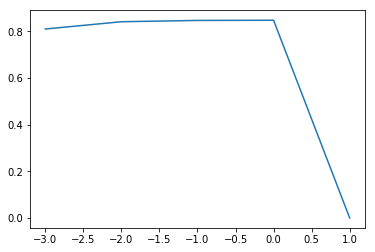

In [62]:
plt.plot(log_values, err)
plt.show()

It seems like weve got the best performances for C between 10r-2 and 10e0. We will thus try c values between 0 and 1.0 ish with a step of .01. 

In [66]:
start = timeit.default_timer()
best_c = -1
best_err = 1000
clfopti = None
step = 0.01
for i in np.arange(0 + step, 1.2, step):
    clftmp = lsvc(C=i)
    err = 1 - np.mean([clftmp.fit(xa[train], ya[train]).score(xa[test], ya[test]) for train, test in kf.split(xa)])
    if err < best_err:
        best_c = i
        best_err = err
        clfopti = clftmp
stop = timeit.default_timer()
print("best c value :", best_c)
print("best error :", best_err)
print("exec time : ", stop - start)

best c value : 1.1300000000000001
best error : 0.15159999999999996
exec time :  102.01746006941309


Pretty close to 1 ! But it feels a bit like overtraining. :( Maybe we should ry with another classifier ?

## Other models


In [2]:
def kfoldscore(classifier, x, y, n):
    kf = KFold(n_splits = n)
    kf.get_n_splits(x)
    return 1 - np.mean([classifier.fit(x[train], y[train]).score(x[test], y[test]) for train, test in kf.split(x)])

### Random forest

In [10]:
rfc = RandomForestClassifier(n_estimators=100)
err = kfoldscore(rfc, xa, ya, 7)
print('kfold err  =', err)

kfold err  = 0.12339817045699397


In [73]:
rfc = RandomForestClassifier()
rfc.fit(xa, ya)
pred_forest = rfc.predict(dt)
np.savetxt('pred_forest.txt', pred_forest)

We obtained 12,5 % error, which is a bit better.

### Adaboost

In [1]:
from sklearn.ensemble import AdaBoostClassifier

In [16]:
abclf = AdaBoostClassifier()
print("kfold err = ", kfoldscore(abclf, xa, ya, 7))

kfold err =  0.15239998097140972


Not very impressive... Let's try boosting our random forest

In [18]:
ada_rand_tree = AdaBoostClassifier(base_estimator=rfc)
print("kfold err = ", kfoldscore(ada_rand_tree, xa, ya, 7))

kfold err =  0.12959701363062692


This is better than well everything we got so far, but only marginally impressive when compared to a simple random forest. And what if we try to boost our first linear SVC ?

In [26]:
ada_lsvc = AdaBoostClassifier(base_estimator=clf, algorithm='SAMME', learning_rate=2, n_estimators=100)
print("kfold err = ", kfoldscore(ada_lsvc, xa, ya, 7))

kfold err =  0.1528018200287109


### Decison Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
dtclf = DecisionTreeClassifier()
print("kfold err = ", kfoldscore(dtclf, xa, ya, 7))

kfold err =  0.1557977036968634


### KNeighbors

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
kclf = KNeighborsClassifier()
print("kfold err = ", kfoldscore(kclf, xa, ya, 7))

kfold err =  0.18379715522572682
